# 인공지능과 가위바위보 하기

|평가문항|상세기준|
|---|---|
|1. 이미지 분류기 모델이 성공적으로 만들어졌는가?|학습과정이 정상적으로 수행되었으며, 학습 결과에 대한 그래프를 시각화(ex. train acc / train loss / val acc / val loss 등) 해 보았음|
|2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?|오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등을 2가지 이상 시도해보았음|
|3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?|60% 이상 도달하였음|

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [27]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [28]:
def load_data(img_path, number_of_data=1530):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=224
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getcwd()
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1530 입니다.
x_train shape: (1530, 224, 224, 3)
y_train shape: (1530,)


라벨:  0


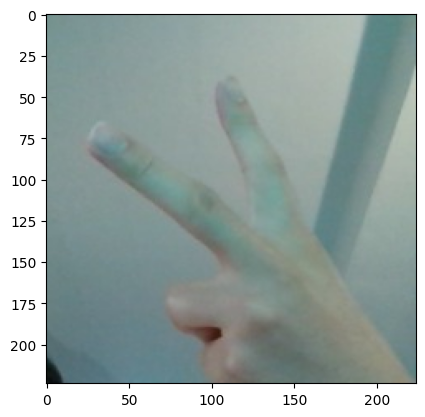

In [29]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [30]:
image_dir_path=image_dir_path+"/test"

(x_test, y_test)=load_data(image_dir_path,number_of_data=300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 224, 224, 3)
y_test shape: (300,)


In [51]:
# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
drop_rate=0.3

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (11,11), activation='relu', input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (10,10), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (10,10), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 214, 214, 16)      5824      
                                                                 
 batch_normalization (BatchN  (None, 214, 214, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 107, 107, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 98, 98, 32)        51232     
                                                                 
 batch_normalization_1 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                      

In [57]:
k = 5
kfold = KFold(n_splits = k)
train_loss = []
val_loss =[]

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

for train_index, val_index in kfold.split(x_train_norm) :
    x_train_fold, x_val_fold = x_train_norm[train_index], x_train_norm[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    hist=model.fit(x_train_fold, y_train_fold, epochs = 10, validation_data = (x_val_fold, y_val_fold))
    val_loss.append(hist.history['val_loss'])
    train_loss.append(hist.history['loss'])

Epoch 1/10
39/39 [==============================] - 68s 2s/step - loss: 0.2684 - accuracy: 0.9616 - val_loss: 7.0540 - val_accuracy: 0.4673
Epoch 2/10
39/39 [==============================] - 68s 2s/step - loss: 0.0579 - accuracy: 0.9910 - val_loss: 24.0894 - val_accuracy: 0.2157
Epoch 3/10
39/39 [==============================] - 68s 2s/step - loss: 0.0218 - accuracy: 0.9975 - val_loss: 9.1448 - val_accuracy: 0.5523
Epoch 4/10
39/39 [==============================] - 69s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 4.0807 - val_accuracy: 0.7680
Epoch 5/10
39/39 [==============================] - 72s 2s/step - loss: 4.7151e-04 - accuracy: 1.0000 - val_loss: 2.6490 - val_accuracy: 0.8007
Epoch 6/10
39/39 [==============================] - 72s 2s/step - loss: 4.7920e-04 - accuracy: 1.0000 - val_loss: 2.0660 - val_accuracy: 0.8203
Epoch 7/10
39/39 [==============================] - 72s 2s/step - loss: 2.5155e-04 - accuracy: 1.0000 - val_loss: 1.8529 - val_accuracy: 0.8170
Epoch 8

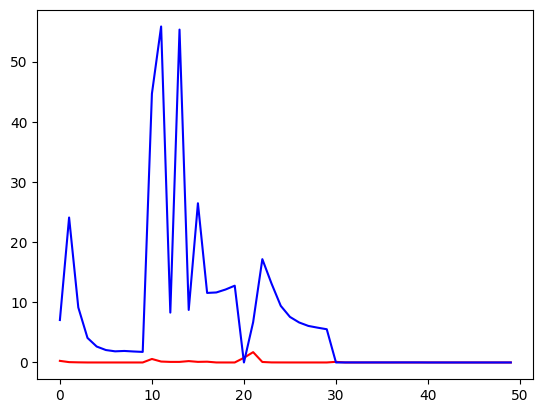

In [58]:
train_loss=np.array(train_loss)
val_loss=np.array(val_loss)
train_loss=train_loss.reshape(train_loss.shape[0]*train_loss.shape[1],1)
val_loss=val_loss.reshape(val_loss.shape[0]*val_loss.shape[1],1)
plt.plot(train_loss,color="red")
plt.plot(val_loss,color="blue")

In [59]:
y_predict=model.predict(x_test_norm)
y_predict

10/10 [==============================] - 3s 301ms/step


array([[5.47474927e-31, 9.99955535e-01, 4.44888537e-05],
       [1.00000000e+00, 5.77251845e-31, 3.76704513e-21],
       [1.00000000e+00, 5.77251845e-31, 3.76704513e-21],
       [1.00000000e+00, 1.62882708e-14, 1.58123742e-12],
       [1.00000000e+00, 6.23362979e-17, 1.08011922e-09],
       [1.00000000e+00, 9.28811249e-18, 5.13623755e-10],
       [1.00000000e+00, 2.60384248e-17, 6.58954835e-11],
       [1.00000000e+00, 1.81350213e-09, 1.43691989e-10],
       [9.99994159e-01, 5.86297119e-06, 2.49561372e-09],
       [9.99725044e-01, 2.74953607e-04, 2.60194213e-08],
       [1.71497316e-09, 0.00000000e+00, 1.00000000e+00],
       [1.64280980e-12, 8.27987183e-36, 1.00000000e+00],
       [9.58894852e-10, 2.25666441e-24, 1.00000000e+00],
       [1.67526829e-03, 6.73204237e-20, 9.98324692e-01],
       [1.67526829e-03, 6.73204237e-20, 9.98324692e-01],
       [6.21627970e-03, 6.52885127e-20, 9.93783712e-01],
       [3.16898897e-03, 3.02690654e-20, 9.96831000e-01],
       [7.56387465e-07, 7.08492

In [60]:
def get_answer(arr):
    ans=[]
    for i in range(len(arr)):
        ans.append(arr[i].argmax())
        
    return ans

mod_y_predict=get_answer(y_predict)
accuracy_score(y_test,mod_y_predict)

0.7066666666666667